# Lab : Support vector machine

**Report** should be written as ipynb. 

Points for lab: 20 

For this lab you need to install CVXOPT solver for quadratic programming [CVXOPT](http://cvxopt.org/)


## 1. Quadratic programming and QP-solver

[Quadratic programming (QP)](https://en.wikipedia.org/wiki/Quadratic_programming) is the process of solving a special type of mathematical optimisation problem—specifically, a (linearly constrained) quadratic optimisation problem, that is, the problem of optimising (minimising or maximising) a quadratic function of several variables subject to linear constraints on these variables.

$$
\begin{array}
[t]{ll}\mbox{minimize} & \frac{1}{2} x^T\boldsymbol Px + \boldsymbol q^T x \\\mbox{subject to} & \boldsymbol Gx \preceq \boldsymbol h \\ & \boldsymbol Ax = \boldsymbol b
\end{array}
$$

Here $\boldsymbol P$ is a symmetric matrix. 

![2D-example](https://optimization.mccormick.northwestern.edu/images/0/07/QPPic.JPG)

Here $\boldsymbol x^* $ is optimal solution, **dotted lines** describe the points with the same value of minimised function, **polyhedron** if constrained by inequalities and equations

### Task:

1. Install QP-solver, understand it's interface http://cvxopt.org/userguide/coneprog.html#quadratic-programming
2. Test solver with that problem:
$$f(\boldsymbol x) = -8x_1 - 5x_2 + x_1^2 + 4x_2^2, 
\\\quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_1 + x_2 \geq 2$$

3. Which inequality constraints are **not active**, that means they do not influence optimal point. Can you delete some constraints without changing optimal point?
 

## 2. Linear SVM

Let's take the binary classification problem. Define train set as $\{(\boldsymbol x_n, y_n)\}_{n=1}^N$, where $N$ - number of train objects, $\boldsymbol x_n \in \mathbb{R}^d$ - feature vectors, $y_n \in \{+1, -1\}$ - object class

SVM trains the model of the separating hyperplane:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$

Model parameters are weight vector $\boldsymbol w \in \mathbb{R}^d$ and bias $b \in \mathbb{R}$

![svm margin explained](svm_margin.png)



To find this hyperplane we will solve next optimization problem:

$$
\begin{array}
[t]{ll}\mbox{minimize}_{\boldsymbol w, \boldsymbol \xi, b} & \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \\
\mbox{subject to} & \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{array}
$$


Constraints $ y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ demand the objects to be correctly classified by hyperplane. Linear separability of dataset in general case is not guranteed, so variables $\xi_n$ (slack variables) relax constraints of correct classification. 
$\| \boldsymbol w \|^2$ in objective function regulate width of separating hyperplane, sum $\sum_n \xi_n$ regulate constraint relaxation

Hyperparameter $C$ sets the balance between the width of separating plane and errors, made by a classifier. Pay attention that $C$ is fixed before training and is not optimised with model's parameters.

That hyperparameter is responsible for generalisation capability of separating hyperplane. The Bigger value corresponds to better generalisation and might lead to overfitting if dataset could be described with a linear model. On choosing optimal $C$ you should evaluate model quality on validation set or use cross-validation. In general, for the particular problem you can't infer the optimal value for $C$ apriori, so you need to try several values. Better to use logarithmic scale, for example:  $10^{-3}, 10^{-2}, \dots, 10^{5}$.

![support_vectors.png](support_vectors.png)

After solving QP optimization problem $(\boldsymbol w^*, \boldsymbol \xi^*, b^*)$, some of the constraints becomes _active_ (become equations):
$$\quad y_n (\boldsymbol w^{*T} \boldsymbol x_n + b^*) = 1 - \xi^*_{n}$$
Objects that correspond to these equations are called **support vectors**

#### Feature constraction/transformation

It is a very rare situation when classes are linearly separable. We can address that problem with feature transformation. The idea is to change feature space in such a way that out linear hyperplane could describe our classes better.

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Simplest transformation suggest to add pairwise multiplication of features: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$. In that space our linear model would correspond to quadratic hyperplane in the initial feature space.

[Demo](https://youtu.be/9NrALgHFwTo)

### Task

1. Reduce SVM optimisation problem to QP, and implement Linear SVM using QP-solver
2. Generate different 2D sample for binary classification task:
    - linearly separable
    - with separable classes, but not linearly
    - not-separable classes in that feature space
3. Test linear SVM on these samples. Draw plots with separating hyperplane, and with level lines, which constraint "street" $f(\boldsymbol x) = \pm 1$. Use different point shape or size for **support vectors**. Build classifier with different $C$
4. How the number of support vectors depends on parameter $C$?
5. Using explicit feature transformation train linear SVM to separate non-leary separable classes with a quadratic hyperplane. Show it on the plot.

# 3. Dual problem and Kernel SVM

Optimisation problem from part #2 is called _primal_ optimisation problem for SVM. Each constrained optimisation problem has **dual** https://en.wikipedia.org/wiki/Duality_(optimisation)#The_strong_Lagrangian_principle:_Lagrange_duality , which optimises _dual variables_ , that correspond to fee for constraint violation. Dual problem maximises lower bound for primal problem. For quadratic programming solution of dual problem (value of a dual objective function) is equal to the optimal solution of the primal task.

This lecture slides might help you http://www.robots.ox.ac.uk/~az/lectures/ml/lect3.pdf

Dual problem for SVM can be written as:


$$
\begin{array}
[t]{ll}\mbox{maximize} \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'}\\ 
    \begin{aligned}
        \text{subject to} \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{array}
$$

We optimize vector of dual variables $\alpha_n$, that correspond to the objects of train set. Objects $x_n$ is support if $\alpha_n > 0$.

Class prediction computed as:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

For proper prediction we must estimate $b$ parameter. For any support vector, that was classifier without errors: 
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
therefore for each such object
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$


If there is errors in test set classification, then you can average $b$ over all support vectors:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$

The idea is following: cumulative errors in a positive direction are almost the same as errors in negative direction.

Other option: refuse from $b$ and work with model $f(x) = w^Tx$ adding to $x$ vector constant feature.


#### Implicit feature transformation

Dual SVM problem containts feature vectors only as a dot product $x^Tx'$. This fact allows as to make implicit feature space transformation. Instead of function $\phi(\boldsymbol x)$, we will compute $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ called _kernel_. 

#### Task

1. Implement kernel SVM, using QP-solver
2. Test linear SVM on these samples. Draw plots with separating hyperplane, and with level lines, which constraint "street" $f(\boldsymbol x) = \pm 1$. Use different point shape or size for **support vectors**. Test different kernels:
    - linear: $k(x, x') = x^Tx'$
    - polynomial:$k(x, x') = (x^Tx' + 1)^d$ of different power $d = 2,3,\dots$
    - gauss-RBG: $k(x, x') = \exp(-\frac{1}{2\sigma}\|x - x'\|^2)$
3. Describe SVM with polynomial kernel behavior when you vary parameters $C$ and kernel degree $d$.
4. Descrive SVM with RBF kernel behavior when you vary $C$ and $\sigma$. Vary parameters at logarithmic scale. Which parameters lead to overfitting, which parameters give low quality model.


# Examples

## Visual solution for QP

Example contains solution for QP from #1. Values of objective function  $f(\boldsymbol x)$ are defined by level-lines, feasibility region is colored in gray. 


C:\Users\Anatoly\Anaconda2\lib\site-packages\matplotlib\contour.py:920: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


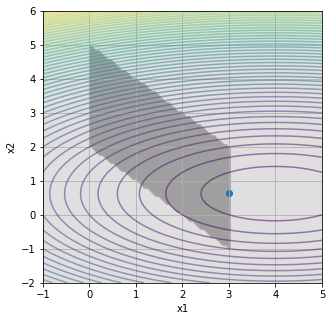

In [143]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x1 = np.linspace(-1, 5, 100)
x2 = np.linspace(-2, 6, 100)
xx1, xx2 = np.meshgrid(x1, x2)

f = -8*xx1 - 5*xx2 + xx1**2 + 4*xx2**2
constr1 = (xx1 + xx2 <= 5)
constr2 = (0 <= xx1) & (xx1 <= 3)
constr3 = (xx2 >= 2-xx1)

plt.figure(figsize=(5, 5))
plt.grid(True)
plt.xlabel('x1')
plt.ylabel('x2')

plt.contour(x1, x2, f, 50, alpha=0.5)
plt.contourf(x1, x2, np.invert(constr1 & constr2 & constr3), 1, alpha=0.5, linewidths=4, cmap='gray')
_ = plt.scatter([3], [0.65])

## `CvxOpt` installation

read the docs

In [3]:
!pip install --upgrade cvxopt

Requirement already up-to-date: cvxopt in /usr/local/lib/python2.7/site-packages
Cleaning up...


Нас будет интересовать функция [`cvxopt.solvers.qp()`](http://cvxopt.org/examples/tutorial/qp.html):

In [4]:
from cvxopt import solvers
?solvers.qp

Very often we have sparse matrix and it is better (by speed and by memmory) to use operations over sparse matrixes.
[Sparse and dense matrix](http://cvxopt.org/userguide/matrices.html)

## Using sklearn to generate datasets for classification task

There is a function for generating random samples for classification in `Scikit-Learn` [`sklearn.datasets.make_classification()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html).

Use `random_state` to get reproducible results

In [144]:
from sklearn.datasets import make_classification
random_state = 4

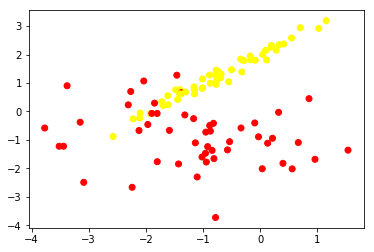

In [145]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=random_state)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

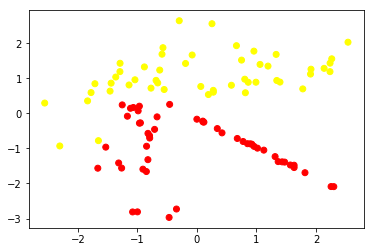

In [146]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=random_state)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

## Separating hyperplane visualisation

[[ 0.8  0.2]
 [ 0.8  0.2]
 [ 0.8  0.2]
 ..., 
 [ 0.   1. ]
 [ 0.   1. ]
 [ 0.   1. ]]


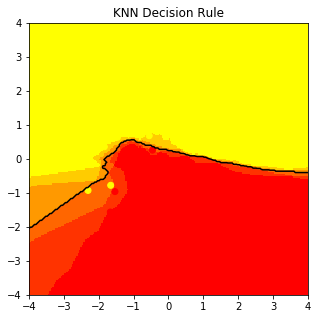

In [148]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

xvals = np.linspace(-4, 4, 200)
yvals = np.linspace(-4, 4, 200)

xx, yy = np.meshgrid(xvals, yvals)
zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1], xx.shape)
print model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
# Decision rule color encoding
plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

# Level lines of 0.5
plt.contour(xx, yy, zz, levels=(0.5,), colors='k', linewidths=1.5, zorder=1)

plt.xlim([-4, 4])
plt.ylim([-4, 4])
_ = plt.title('KNN Decision Rule')

## Using SciKit-Learn model estimator interface for custom SVM implementation

In the tasks ( #2, #3 ) you need to implement SVM classifier's train algorithm. In order to use full power of Scikit-Learn (model evaluation, parameter grid search, cross-validations, metrics and so on) you need to implement base interface [`BaseEstimator`](http://scikit-learn.org/stable/developers/#estimators)


In [9]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, y):
        """
        Train function
        """
        dim = X.shape[1]
        self.weights_ = np.empty(dim)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        return (np.dot(X, self.weights_) + self.bias_).flatten()
            
    def predict(self, X):
        return np.sign(self.predict_proba(X))

# ------------------------------------------------------------------------------------

In [1]:
import numpy as np
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
%matplotlib inline

random_state = 0

# 1. Quadratic programming and QP-solver

## - Install QP-solver, understand it's interface

In [2]:
#!pip install --upgrade cvxopt
from cvxopt import matrix, solvers

## - Test solver with that problem

In [3]:
P = 2*matrix([[1.0, 0.0], [0.0, 4.0] ])
q = matrix([-8.0, -5.0])
G = matrix([[1.0, 1.0],[-1.0, 0.0], [1.0, 0.0], [-1.0, -1.0]]).trans()
h = matrix([5.0, 0.0, 3.0, -2.0])

sol=solvers.qp(P, q, G, h)

print sol['x']
# x1^2 + 4 * x2^2 - 8*x1 - 5*x2

     pcost       dcost       gap    pres   dres
 0: -1.6087e+01 -2.6485e+01  1e+01  0e+00  2e-16
 1: -1.6449e+01 -1.6944e+01  5e-01  2e-16  6e-17
 2: -1.6561e+01 -1.6569e+01  8e-03  1e-16  6e-17
 3: -1.6562e+01 -1.6563e+01  8e-05  7e-17  1e-17
 4: -1.6562e+01 -1.6563e+01  8e-07  1e-16  2e-17
Optimal solution found.
[ 3.00e+00]
[ 6.25e-01]



## - Which inequality constraints are not active, that means they do not influence optimal point. Can you delete some constraints without changing optimal point?

We could remove further constraints without changing optimal point:
$$ x_1 + x_2 \leq 5, \; x_1 \geq 0,\; x_1 + x_2 \geq 2$$

In [4]:
G1 = matrix([[1.0, 0.0]]).trans()
h1 = matrix([3.0])
sol=solvers.qp(P, q, G1, h1)
print sol['x']

     pcost       dcost       gap    pres   dres
 0: -1.7451e+01 -1.7007e+01  7e-01  6e-01  1e-16
 1: -1.7202e+01 -1.6722e+01  1e-02  1e-01  7e-17
 2: -1.6554e+01 -1.6563e+01  8e-03  0e+00  2e-16
 3: -1.6562e+01 -1.6563e+01  8e-05  1e-16  0e+00
 4: -1.6562e+01 -1.6563e+01  8e-07  0e+00  5e-17
Optimal solution found.
[ 3.00e+00]
[ 6.25e-01]



# 2. Linear SVM

## - Reduce SVM optimisation problem to QP, and implement Linear SVM using QP-solver

In [22]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, y):
        """
        Train function
        """
        n_samples, n_features = X.shape
        dim = n_samples + n_features + 1
        qp_sol = self._qp(X, y)
        self.weights_ = qp_sol['x'][:n_features]
        self.bias_ = qp_sol['x'][len(qp_sol['x']) - 1]
        return {'weights': self.weights_, 'bias': self.bias_}
    
    def _qp_P(self, X):
        n_samples, n_features = X.shape
        dim = n_samples + n_features + 1 # dim(w, psi, b)
        P = np.zeros((dim, dim))
        for i in range(n_features):
            P[i][i] = 1
        return P
    
    def _qp_q(self, X):
        n_samples, n_features = X.shape
        dim = n_samples + n_features + 1
        q = np.zeros(dim)
        for i in range(n_samples):
            q[n_features + i] = self.C
        return q
    
    def _qp_G(self, X, y):
        n_samples, n_features = X.shape
        dim = n_samples + n_features + 1
        G = np.zeros((2 * n_samples, dim))
        for i in range(n_samples):
            for j in range(n_features):
                G[i][j] = -y[i] * X[i][j]
            G[i][n_features + i] = -1
            G[i][dim - 1] = y[i]
            G[n_samples + i][n_features + i] = -1
        return G          
    
    def _qp_h(self, X):
        n_samples, n_features = X.shape
        return np.append(-np.ones(n_samples), np.zeros(n_samples))
    
    def _qp(self, X, y):
        P = 2 * matrix(self._qp_P(X).astype(np.double))
        q = matrix(self._qp_q(X).astype(np.double))
        G = matrix(self._qp_G(X, y).astype(np.double))
        h = matrix(self._qp_h(X).astype(np.double))
        return solvers.qp(P, q, G, h)
    
    def predict_proba(self, X):
        return (np.dot(X, self.weights_) + self.bias_).flatten()
        
    def predict(self, X):
        return np.sign(self.predict_proba(X))

## - Generate different 2D sample for binary classification task:

* linearly separable

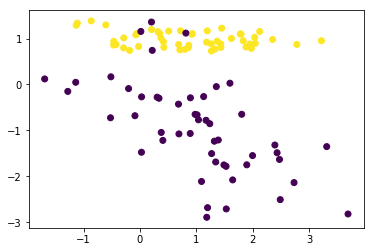

In [10]:
lin = {}
lin['X'], lin['y'] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=random_state)
replace_zero = lambda x: -1 if x==0 else x
lin['y'] = [replace_zero(x) for x in lin['y']]
plt.scatter(lin['X'][:, 0], lin['X'][:, 1], c=lin['y'])

* with separable classes, but not linearly

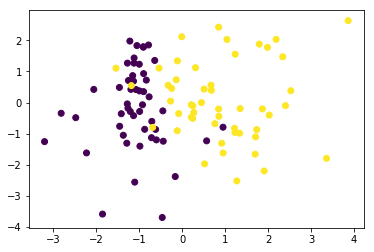

In [15]:
non_lin = {}
non_lin['X'], non_lin['y'] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=random_state)
non_lin['y'] = [replace_zero(x) for x in non_lin['y']]
plt.scatter(non_lin['X'][:, 0], non_lin['X'][:, 1], c=non_lin['y'])

* not-separable classes in that feature space

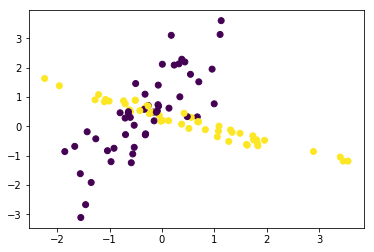

In [16]:
non_sep = {}
non_sep['X'], non_sep['y'] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, hypercube=False, random_state=random_state)
non_sep['y'] = [replace_zero(x) for x in non_sep['y']]
plt.scatter(non_sep['X'][:, 0], non_sep['X'][:, 1], c=non_sep['y'])

## - Test linear SVM on these samples. Draw plots with separating hyperplane, and with level lines, which constraint "street"  f(x)=±1f(x)=±1 . Use different point shape or size for support vectors. Build classifier with different  C


In [17]:
def plot(model, samples):
    plt.figure(figsize=(5, 5))
    plt.scatter(samples['X'][:, 0], samples['X'][:, 1], c=samples['y'], cmap='autumn')

    xvals = np.linspace(-4, 4, 100)
    yvals = np.linspace(-4, 4, 100)

    xx, yy = np.meshgrid(xvals, yvals)
    proba = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    #print proba
    shape = xx.shape
    zz = np.reshape(proba, shape)
    # Decision rule color encoding
    #plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

    # Level lines of 0.5
    plt.contour(xx, yy, zz, levels=(0.5,), colors='k', linewidths=1.5, zorder=1)

    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    _ = plt.title('')

* linearly separable

     pcost       dcost       gap    pres   dres
 0:  1.5031e+00  3.6813e+01  7e+02  3e+00  2e+02
 1:  1.9617e+01 -1.7476e+01  4e+01  9e-02  6e+00
 2:  7.9078e+00  2.5455e+00  5e+00  5e-16  1e-15
 3:  3.8190e+00  3.0321e+00  8e-01  3e-16  6e-16
 4:  3.5039e+00  3.3529e+00  2e-01  2e-16  4e-15
 5:  3.4457e+00  3.4215e+00  2e-02  2e-16  1e-15
 6:  3.4352e+00  3.4310e+00  4e-03  2e-16  3e-15
 7:  3.4336e+00  3.4327e+00  9e-04  3e-16  7e-16
 8:  3.4332e+00  3.4332e+00  3e-05  2e-16  5e-15
 9:  3.4332e+00  3.4332e+00  3e-07  3e-16  1e-14
Optimal solution found.
[ 1.69e-01]
[ 1.11e+00]



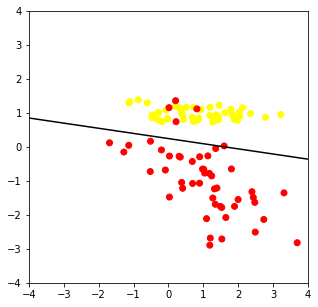

In [34]:
svm = LinearSVM(C=1E-1)
fitting = svm.fit(lin['X'], lin['y'])
print fitting['weights']
plot(svm, lin)

with another C constant:

     pcost       dcost       gap    pres   dres
 0: -6.4107e+01  2.3122e+02  1e+03  4e+00  2e+01
 1:  1.1297e+02 -5.8190e+01  2e+02  5e-01  2e+00
 2:  3.7213e+01  6.7372e+00  3e+01  5e-02  2e-01
 3:  2.0291e+01  1.3403e+01  8e+00  9e-03  4e-02
 4:  1.8778e+01  1.5457e+01  4e+00  3e-03  1e-02
 5:  1.7321e+01  1.6529e+01  8e-01  6e-04  3e-03
 6:  1.6977e+01  1.6804e+01  2e-01  1e-04  5e-04
 7:  1.6891e+01  1.6876e+01  2e-02  4e-06  2e-05
 8:  1.6883e+01  1.6882e+01  3e-04  8e-08  4e-07
 9:  1.6883e+01  1.6883e+01  3e-06  8e-10  4e-09
Optimal solution found.
[ 2.54e-01]
[ 1.94e+00]



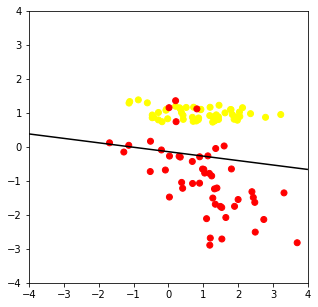

In [35]:
svm = LinearSVM(C=1E-0)
fitting = svm.fit(lin['X'], lin['y'])
print fitting['weights']
plot(svm, lin)

* with separable classes, but not linearly

     pcost       dcost       gap    pres   dres
 0:  1.9178e+00  4.3824e+01  7e+02  3e+00  2e+02
 1:  1.9374e+01 -2.4612e+01  5e+01  1e-01  9e+00
 2:  1.0408e+01  3.1968e+00  7e+00  5e-16  2e-15
 3:  4.7920e+00  3.8266e+00  1e+00  4e-16  4e-16
 4:  4.3884e+00  4.2257e+00  2e-01  3e-16  8e-16
 5:  4.3291e+00  4.2824e+00  5e-02  3e-16  3e-15
 6:  4.3078e+00  4.3028e+00  5e-03  3e-16  1e-15
 7:  4.3054e+00  4.3051e+00  4e-04  3e-16  7e-14
 8:  4.3053e+00  4.3052e+00  9e-06  3e-16  4e-13
 9:  4.3053e+00  4.3053e+00  3e-07  2e-16  3e-12
Optimal solution found.
[ 1.04e+00]
[ 7.33e-02]



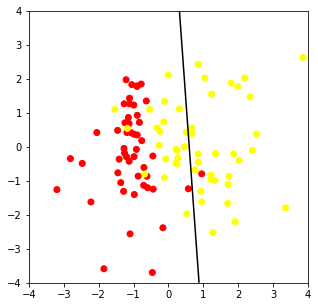

In [48]:
svm = LinearSVM(C=1E-1)
fitting = svm.fit(non_lin['X'], non_lin['y'])
print fitting['weights']
plot(svm, non_lin)

* not-separable classes in that feature space

     pcost       dcost       gap    pres   dres
 0:  3.9150e+00  6.6795e+01  7e+02  3e+00  9e+01
 1:  2.2496e+01 -4.5284e+00  3e+01  5e-02  2e+00
 2:  9.5801e+00  7.0338e+00  3e+00  4e-16  1e-15
 3:  8.4610e+00  7.7212e+00  7e-01  2e-16  2e-15
 4:  8.2222e+00  7.9394e+00  3e-01  3e-16  5e-15
 5:  8.1250e+00  8.0450e+00  8e-02  2e-16  4e-15
 6:  8.0929e+00  8.0813e+00  1e-02  3e-16  1e-14
 7:  8.0869e+00  8.0864e+00  5e-04  3e-16  5e-15
 8:  8.0867e+00  8.0866e+00  5e-05  3e-16  1e-13
 9:  8.0867e+00  8.0867e+00  5e-07  3e-16  1e-13
Optimal solution found.
[ 6.73e-01]
[-2.47e-01]



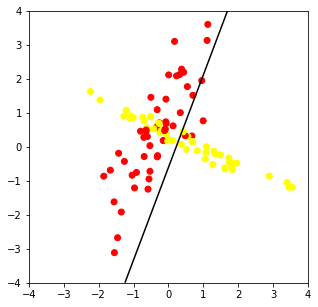

In [49]:
fitting = svm.fit(non_sep['X'], non_sep['y'])
print fitting['weights']
plot(svm, non_sep)

## - How the number of support vectors depends on parameter  C ?

Bigger C value gives us bigger margin so there will be more support vectors

## - Using explicit feature transformation train linear SVM to separate non-linearly separable classes with a quadratic hyperplane. Show it on the plot

# 3. Dual problem and Kernel SVM

## - Implement kernel SVM, using QP-solver